In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp

In [2]:
adata = sc.read_h5ad('/mnt/d/StereoNote MPE Leiden.anno.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 51495 × 32838
    obs: 'orig.ident', 'x', 'y', 'condition', 'batch', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'leiden', 'anno'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'condition_colors', 'dendrogram_condition', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm:

In [4]:
def kegg_enrichment(gene_list, file_name_prefix):
    # enrichment analysis
    enr = gp.enrich(gene_list,
                    gene_sets="KEGG_2021_Human",
                    outdir=None)
    # filtering p value is more than 0.05
    result = enr.res2d[enr.res2d['P-value'] < 0.05]
    # save result
    result.to_csv(f"/mnt/c/Users/ouyangkang/Desktop/{file_name_prefix}_result.csv", index=None)

    return result

In [15]:
sc.tl.rank_genes_groups(adata, 'anno', method='wilcoxon')

In [16]:
# DEGs extraction
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [17]:
degs.head()

,T cell_names,T cell_scores,T cell_pvals,T cell_pvals_adj,T cell_logfoldchanges,Myeloid cell_names,Myeloid cell_scores,Myeloid cell_pvals,Myeloid cell_pvals_adj,Myeloid cell_logfoldchanges,cancer cell_names,cancer cell_scores,cancer cell_pvals,cancer cell_pvals_adj,cancer cell_logfoldchanges,B cell_names,B cell_scores,B cell_pvals,B cell_pvals_adj,B cell_logfoldchanges
0,GAS5,86.765877,0.0,0.0,1.472509,SLC8A1,106.746140,0.0,0.0,4.228250,FAM155A,97.021393,0.0,0.0,5.983891,BANK1,69.799240,0.0,0.0,4.416986
1,ANK3,84.472206,0.0,0.0,1.608707,NAMPT,104.329880,0.0,0.0,3.568717,GPC6,84.492165,0.0,0.0,5.211371,AFF3,68.576752,0.0,0.0,4.073521
2,SNHG1,79.077698,0.0,0.0,1.252709,PLXDC2,101.054863,0.0,0.0,4.132961,SDK1,77.972549,0.0,0.0,4.548485,RALGPS2,45.147701,0.0,0.0,3.516253
3,IL7R,74.734299,0.0,0.0,2.288682,VCAN,100.990387,0.0,0.0,4.374806,MEG3,76.878708,0.0,0.0,6.394460,EBF1,43.945080,0.0,0.0,3.873964
4,PDE3B,72.396164,0.0,0.0,1.344497,ZEB2,98.681931,0.0,0.0,3.109657,RALYL,72.110115,0.0,0.0,5.610745,CD74,40.535522,0.0,0.0,2.503933


In [45]:
idx = "cancer cell"
result_df = degs[[col for col in degs if idx in col]]

In [46]:
tem_df = result_df[result_df[idx + "_logfoldchanges"] > 1]
tem_df = tem_df[tem_df[idx + "_pvals"] < 0.05]

In [49]:
kegg_result = kegg_enrichment(tem_df[idx + '_names'][:50], idx)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


<Axes: title={'center': 'KEGG of cancer cell'}, xlabel='$- \\log_{10}$ (P-value)'>

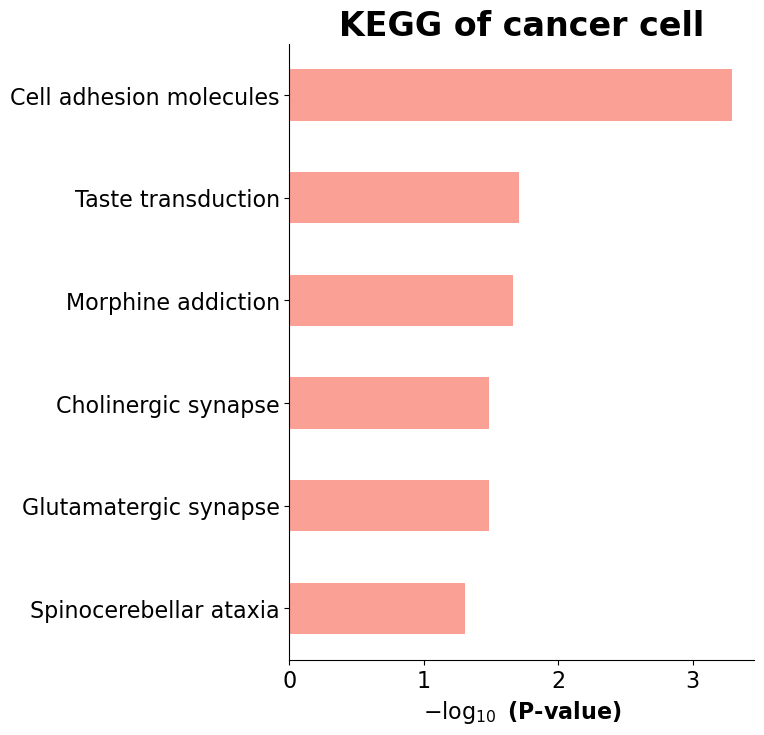

In [50]:
gp.barplot(
    kegg_result,
    figsize=(6, 8),
    title="KEGG of " + idx,
    # group="Lable",
    # color=["b", "r"],
    column="P-value",
    # ofname = "MGL-MAC_diff_function.pdf"
)

In [38]:
idx = "Myeloid cell"
result_df = degs[[col for col in degs if idx in col]]

In [39]:
tem_df = result_df[result_df[idx + "_logfoldchanges"] > 1]
tem_df = tem_df[tem_df[idx + "_pvals"] < 0.05]

In [41]:
kegg_result = kegg_enrichment(tem_df[idx + '_names'][:50], idx)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


<Axes: title={'center': 'KEGG of Myeloid cell'}, xlabel='$- \\log_{10}$ (P-value)'>

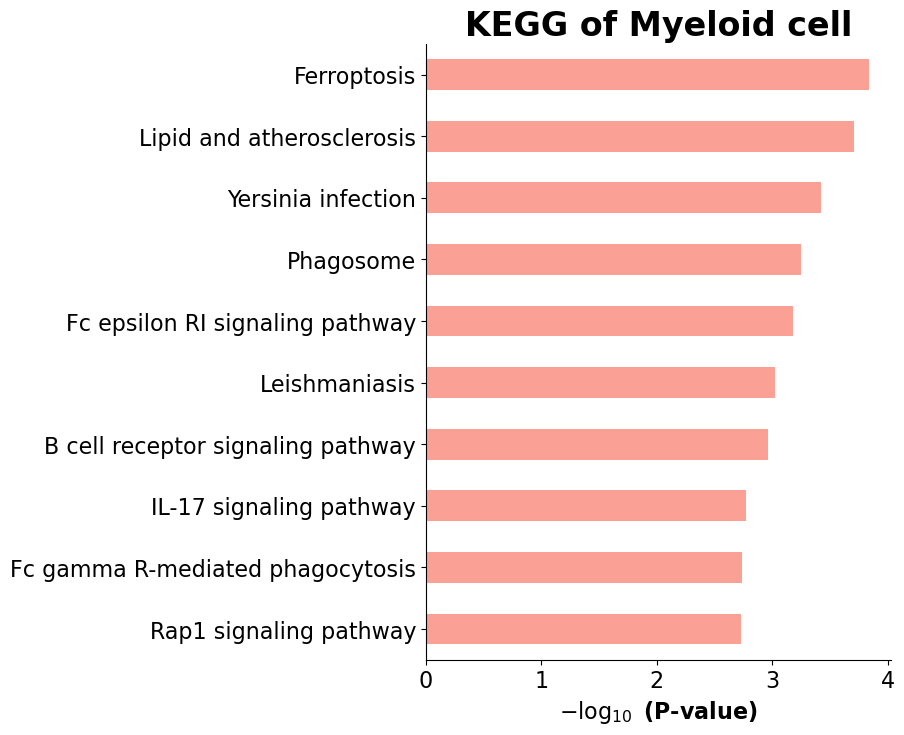

In [44]:
gp.barplot(
    kegg_result,
    figsize=(6, 8),
    title="KEGG of " + idx,
    # group="Lable",
    # color=["b", "r"],
    column="P-value",
    # ofname = "MGL-MAC_diff_function.pdf"
)